The task is to predict the genre of the film by a provided dialogue. We have 20 genres in total. 
Each film can have several genres (Multilabel classification).

The competition is assessed using the Mean F1-Score. For local validation, you can use the 
sklearn.metrics.f1_score (true, preds, average = 'samples') function

In [1]:
import pandas as pd
import ast
import numpy as np
import re
from sklearn import linear_model, metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
target = data_train['genres'].apply(ast.literal_eval) 
data_train = data_train.drop(['genres'],axis = 'columns')

In [3]:
def text(s):
    s = s.lower()
    s = re.sub('<br>'," ",s)
    s = re.sub('</u>'," ",s)
    s = re.sub('<u>'," ",s)
    s = re.sub(r'[^\w\s]',' ',s,flags=re.UNICODE)
    s = ' '.join(s.split())
    return(s)

In [4]:
for i in range(data_test.shape[0]):
    s = text(data_test.iloc[i,1])
    data_test.iloc[i,1] =  s

data_test.head()

,id,dialogue
0,0,boy did you see the way mama whopped that depu...
1,1,gordon the insurance people are balking on the...
2,2,very fancy did you design the bottle who else ...
3,3,it makes me so mad steven schwimmer ready to s...
4,4,something ought to loosen him up how comes we ...


In [5]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


In [6]:
data_test['dialogue'] = data_test['dialogue'].apply(lambda x: remove_stopwords(x))
data_test.head()

,id,dialogue
0,0,boy see way mama whopped deputy shoe knocked g...
1,1,gordon insurance people balking logging trucks...
2,2,fancy design bottle else one runs estates risk...
3,3,makes mad steven schwimmer ready strike exterm...
4,4,something ought loosen comes going el paso rud...


In [7]:
for i in range(data_train.shape[0]):
    s = text(data_train.iloc[i,2])
    data_train.iloc[i,2] =  s

data_train.head()

,id,movie,dialogue
0,0,0,i thought you were in a meeting i am with you
1,1,1,are you sure you re okay you re pale i feel li...
2,2,2,go on get out mom look don t say anything firs...
3,3,3,i could have lost my fucking hands that would ...
4,4,4,stick with me on this gloria i need you and if...


In [8]:
data_train['dialogue'] = data_train['dialogue'].apply(lambda x: remove_stopwords(x))
data_train.head()

,id,movie,dialogue
0,0,0,thought meeting
1,1,1,sure okay pale feel like shit frigging noseble...
2,2,2,go get mom look say anything first pregnant
3,3,3,could lost fucking hands would kept magic circ...
4,4,4,stick gloria need teeth suzie give wrong teeth...


In [9]:
mlb = MultiLabelBinarizer()
mlb.fit([ ["action","adventure","animation","biography","comedy","crime","drama","family","fantasy","history","horror",
                "music","musical","mystery","romance","sci-fi","sport","thriller","war","western"]])
target= pd.DataFrame(mlb.fit_transform(target), index=target.index, columns=mlb.classes_)
target.head()

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [10]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

vectorized_data_train = vectorizer.fit_transform(data_train['dialogue'])
vectorized_data_test = vectorizer.transform(data_test['dialogue'])

In [11]:
x_train, x_test, y_train, y_test = train_test_split(vectorized_data_train,target, test_size=0.25)

In [12]:
lr = OneVsRestClassifier(linear_model.LogisticRegression(max_iter=1000))

In [13]:
lr.fit(x_train,y_train)
pred_proba = lr.predict_proba(x_test)

26


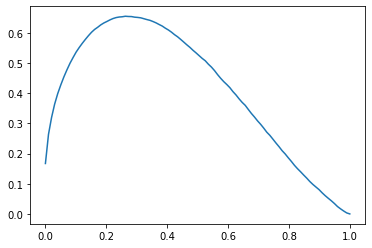

In [14]:
t_s = np.linspace(0,1,100)
metrs = []
for t in t_s:
    preds = (pred_proba >= t).astype(int)
    metr = metrics.f1_score(y_test, preds, average = 'samples')
    metrs.append(metr)
    
plt.plot(t_s,metrs)
t_opt = np.argmax(metrs)
print(t_opt)

In [15]:
print(t_s[t_opt])
print(metrs[t_opt])

0.26262626262626265
0.6547262900258142


In [16]:
pred_proba = lr.predict_proba(vectorized_data_test)
predictions = (pred_proba >= t_s[t_opt]).astype(int)
  

In [17]:
result = mlb.inverse_transform(predictions)

In [18]:
n = len(predictions)
L = [['drama'] for i in range(n)]
df = pd.DataFrame(L, columns=['genres'])

for i in range(n):
    if result[i] != ():
        tmp = result[i][0]
        for j in range(1,len(result[i])):
            tmp = tmp + " " + result[i][j]
        df.loc[i,'genres'] = tmp
    
df.head(20)

,genres
0,crime drama thriller
1,drama thriller
2,drama
3,drama
4,action thriller
5,drama romance
6,comedy drama romance
7,comedy drama romance
8,drama
9,action drama


In [19]:
df.to_csv("genre_prediction.csv")
